In [1]:
# Importing libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Set max row to 300
pd.set_option('display.max_rows', 300)

In [7]:
class BS:
    
    """
    This is a class for options contract for pricing european options on stocks without dividends.
    
    Attributes:
        spot        : int or float
        strike      : int or float
        rate        : float
        dte         : int or float [days to expiration in number os years]
        volatility  : float
    """
    
    def __init__(self, spot, strike, rate, dte, volatility):
        
        # Spot price
        self.spot = spot
        
        # Option strike
        self.strike = strike
        
        # Interest rate
        self.rate = rate
        
        # Days to Expire
        self.dte = dte
        
        # Volatility
        self.volatility = volatility
        
        # Utility
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + (self.rate + (self.volatility**2)/2)*self.dte) / self._a_
            
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = e**-(self.rate * self.dte)
        
        # The __dict__ attribute
        """
        Contains all the attributes defined for the object itself. It maps the attribute name to its value
        """
        
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', 
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price
        [self.callDelta, self.putDelta] = self._delta
        [self.callTheta, self.putTheta] = self._theta
        [self.callRho, self.putPrice] = self._rho
        self.vega = self._vega
        self.gamma = self._gamma
    
        
    # Option price
    @property
    def _price(self):
        """
        Returns the option price: [Call price, Put price]
        """      
        
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e **(-self.rate * self.dte)*norm.cdf(self._d2_)
            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - self.spot * norm.cdf(-self._d1_)
            
        return [call, put]
    
    # Option delta
    @property
    def _delta(self):
        """
        Returns the option delta: [Call delta, Put delta]
        """
        
        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        
        return [call, put]
    
    # Option gamma
    @property
    def _gamma(self):
        """
        Returns the option gamma
        """        
        return norm.pdf(self._d1_) / (self.spot * self._a_)
    
    # Option vega
    @property
    def _vega(self):
        """
        Returns the option vega
        """
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100
        
    # Option theta
    @property
    def _theta(self):
        """
        Returns the option theta: [Call theta, Put theta]
        """
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - \
            self.rate * self.strike * self._b_ * norm.cdf(self._d2_)
            
        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - \
            self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
            
        return [call/365, put/365]
        
    # Option rho
    @property
    def _rho(self):
        """
        Returns the option rho: [Call rho, Put rho]
        """
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        
        return [call, put]

In [8]:
# Initialize option
option = BS(100, 100, 0.05, 1, 0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table, header))

  Option Price     Delta     Gamma       Theta     Vega       Rho
--------------  --------  --------  ----------  -------  --------
       10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


In [11]:
# Initialize option
option = BS(100, 100, 0.05, 1, 0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table, header))

  Option Price     Delta     Gamma       Theta     Vega       Rho
--------------  --------  --------  ----------  -------  --------
       10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


In [12]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2023-08-25')

In [13]:
from datetime import datetime
dte = (datetime(2023, 8, 25) - datetime.today()).days/365

In [14]:
# August 2023 450 SPY call option price
spot = 445; strike = 450; rate = 0.0; dte = dte; vol = 0.1248

spy_opt = BS(spot, strike, rate, dte, vol)
print(f'Option Price of SPY230825C00450000 with BS Model is {spy_opt.callPrice:0.4f}')

Option Price of SPY230825C00450000 with BS Model is 0.2275


In [15]:
# Verify the options output
options.calls.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY230825C00275000,2023-08-22 15:05:15+00:00,275.0,164.61,163.33,163.5,-0.279999,-0.169809,3.0,95,0.00001,True,REGULAR,USD
1,SPY230825C00280000,2023-08-22 16:03:42+00:00,280.0,158.91,158.13,158.3,1.400009,0.888838,3.0,86,0.00001,True,REGULAR,USD


In [19]:
# Filter calls for strike at or above 450
df = options.calls[(options.calls['strike'] >= 450) & (options.calls['strike'] <= 500)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'],
                   'Price': df['lastPrice'],
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0

for i in range(len(df)):
    df['Delta'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).callTheta

# Check output
df.head(2)

/tmp/ipykernel_15982/2291619220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Delta'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).callDelta
/tmp/ipykernel_15982/2291619220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gamma'].iloc[i] = BS(spot, df['Strike'].iloc[i], rate, dte, df['ImpVol'].iloc[i]).gamma
/tmp/ipykernel_15982/2291619220.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,450.0,0.13,0.146005,0.151876,0.048882,0.077441,-0.282670
1,451.0,0.11,0.150887,0.116332,0.039373,0.064463,-0.243168


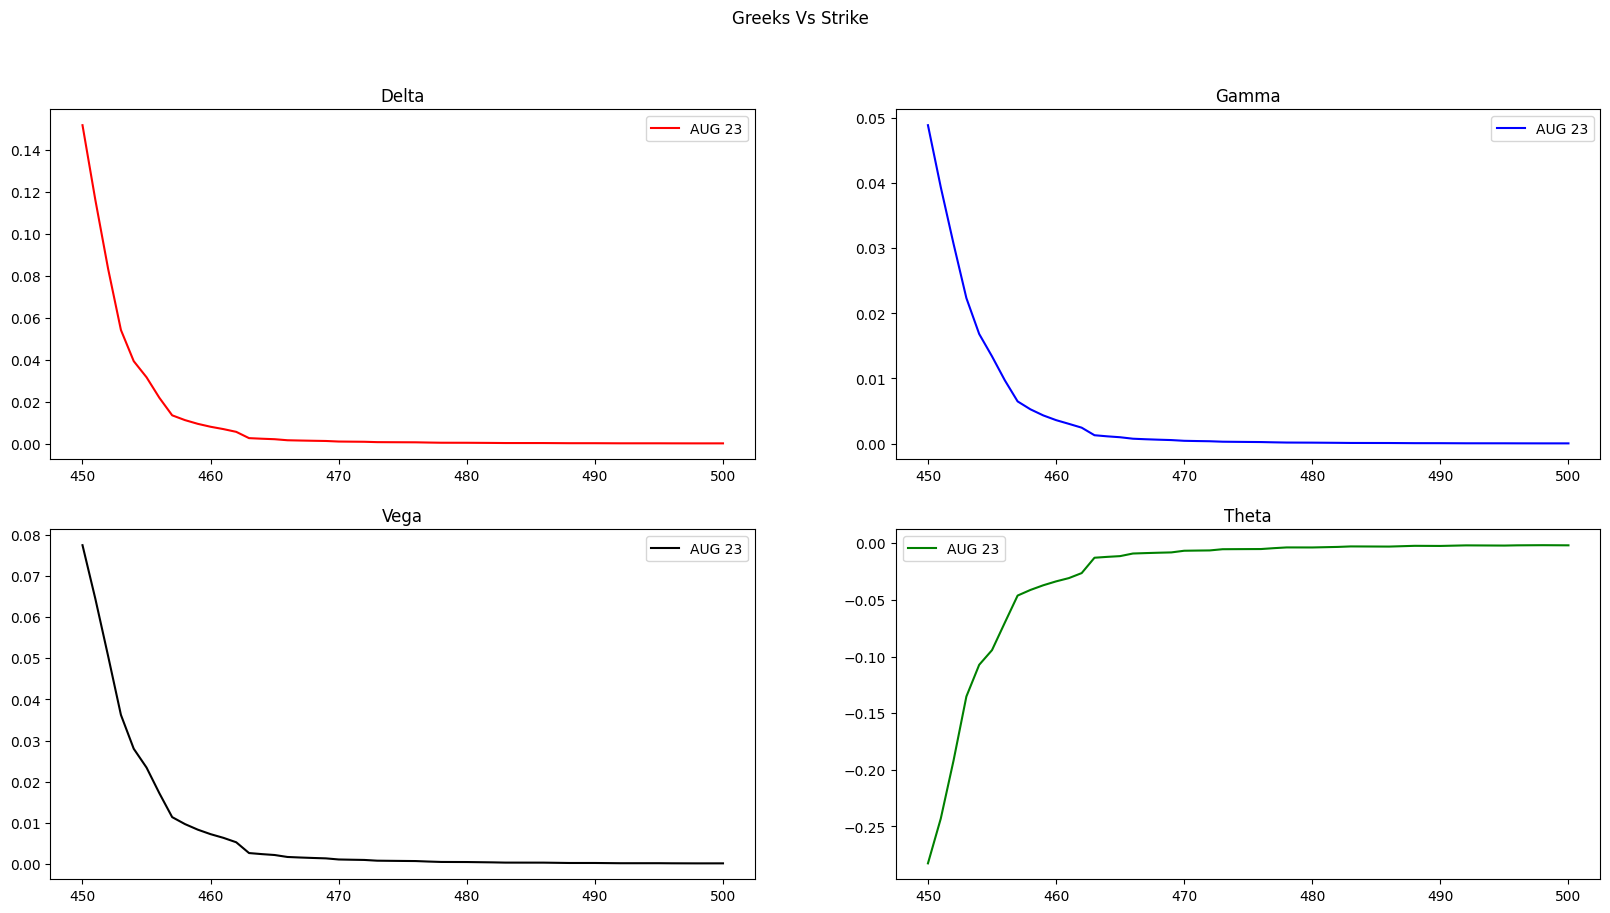

In [21]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20, 10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='AUG 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='AUG 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='AUG 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='AUG 23')

# Set axis title
ax[0,0].set_title('Delta')
ax[0,1].set_title('Gamma')
ax[1,0].set_title('Vega')
ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()